# **CS 181 HW4 Problem 2**

Only code you have to write are places marked with a TODO comment.

#### Loading datasets for K-Means and HAC:

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
from scipy.spatial import distance
from scipy.spatial.distance import cdist


small_dataset = np.load("data/small_dataset.npy")
small_labels = np.load("data/small_dataset_labels.npy").astype(int)
large_dataset = np.load("data/large_dataset.npy")

## K-Means

In [37]:
class KMeans(object):
    # K is the K in KMeans
    def __init__(self, K):
        self.K = K
        self.centroids = None
        self.cluster_assignments = None
        self.objective_history = []

    # X is a (N x 28 x 28) array where 28x28 is the dimensions of each of the N images.
    def fit(self, X):
        N, D = X.shape
        self.centroids = X[np.random.choice(N, self.K, replace=False), :]
        while True:
            distances = np.sqrt(((X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :]) ** 2).sum(axis=2))
            assignments = np.argmin(distances, axis=1)
            new_centroids = np.array([X[assignments == k].mean(axis=0) for k in range(self.K)])
            # Objective function calculation
            objective = np.sum((X - self.centroids[assignments]) ** 2)
            self.objective_history.append(objective)
            if np.all(new_centroids == self.centroids):
                break
            self.centroids = new_centroids
            self.cluster_assignments = assignments

    # This should return the arrays for K images. Each image should represent the mean of each of the fitted clusters.
    def get_mean_images(self):
        # Each mean image is a centroid reshaped back to the original image shape
        return self.centroids
    
    # TODO: change this for part 1's plot
    def plot_verify_objective(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.objective_history, marker='o')
        plt.title("K-Means Objective Function Over Iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Objective Function (RSS)")
        plt.grid(True)
        plt.show()
    
    # TODO: change this for part 5
    def get_cluster_sizes(self):
        # Count the number of data points in each cluster
        cluster_sizes = [np.sum(self.cluster_assignments == k) for k in range(self.K)]
        return cluster_sizes

### Part 1: This takes seconds to run

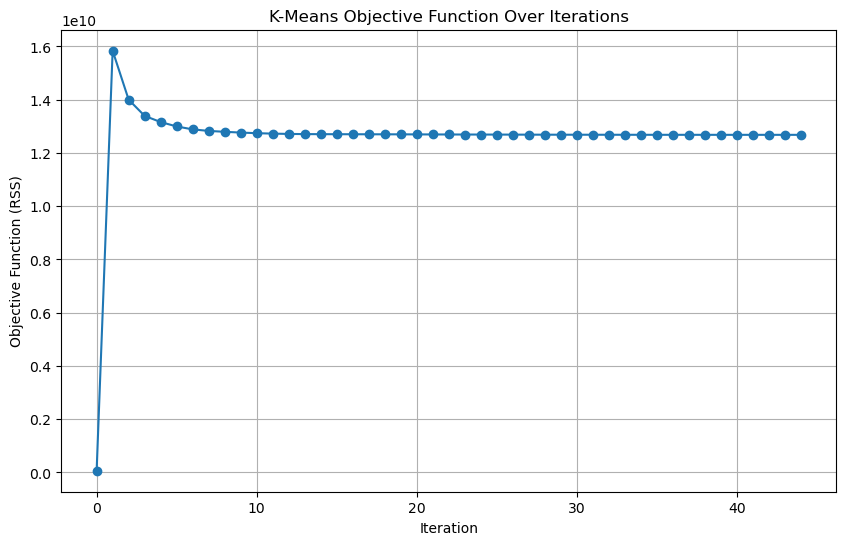

In [36]:
KMeansClassifier = KMeans(K=10)
KMeansClassifier.fit(large_dataset)
KMeansClassifier.plot_verify_objective()

Plotting code for parts 2 and 3

In [17]:
def make_mean_image_plot(data, standardized = False):
    niters = 3
    K = 10
    allmeans = np.zeros((K, niters, 784))
    for i in range(niters):
        KMeansClassifier = KMeans(K=K)
        KMeansClassifier.fit(data)
        allmeans[:,i] = KMeansClassifier.get_mean_images()
    fig = plt.figure(figsize=(10,10))
    plt.suptitle('Class mean images across random restarts' + (' (standardized data)' if standardized else ''), fontsize=16)
    for k in range(K):
        for i in range(niters):
            ax = fig.add_subplot(K, niters, 1+niters*k+i)
            plt.setp(ax.get_xticklabels(), visible=False)
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.tick_params(axis='both', which='both', length=0)
            if k == 0: plt.title('Iter '+str(i))
            if i == 0: ax.set_ylabel('Class '+str(k), rotation=90)
            plt.imshow(allmeans[k,i].reshape(28,28), cmap='Greys_r')
    plt.show()

### Part 2: This takes ~3 minutes to run

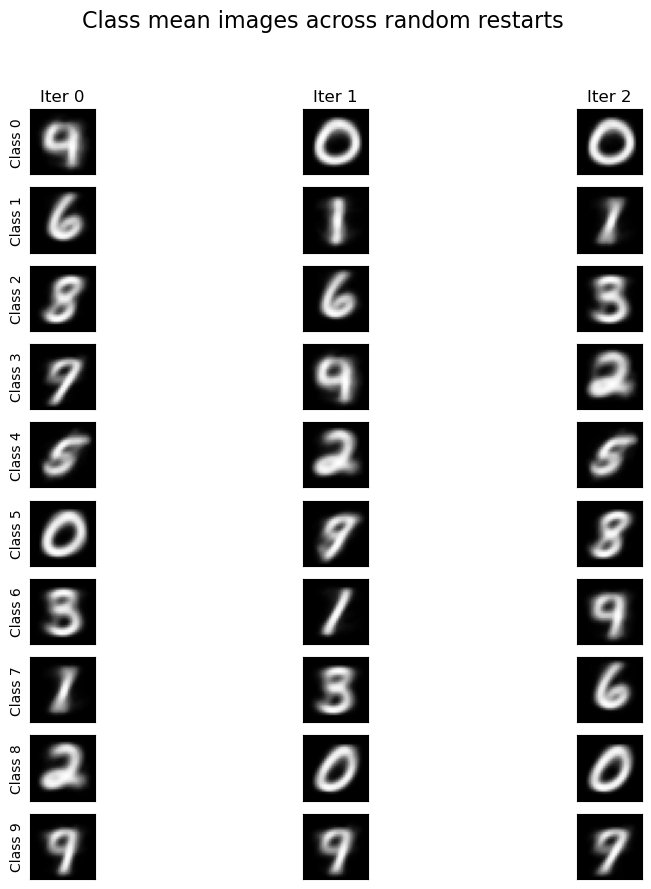

In [18]:
make_mean_image_plot(large_dataset)

### Part 3: This takes ~3 minutes to run

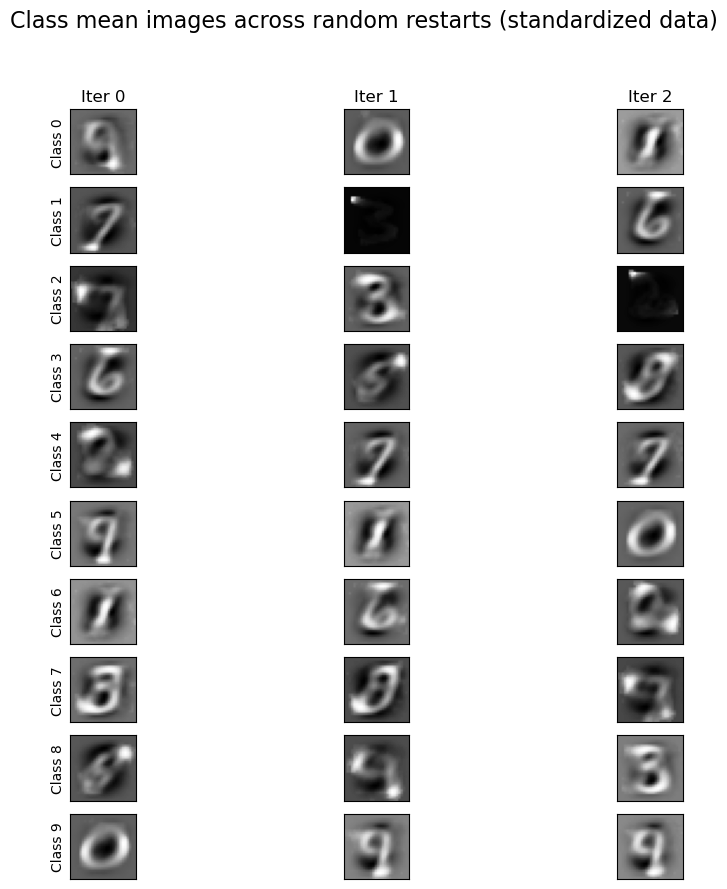

In [19]:
def standardize_data(X):
    # Ensure we don't divide by zero for pixels with zero variance
    stds = np.std(X, axis=0)
    stds[stds == 0] = 1
    standardized_X = (X - np.mean(X, axis=0)) / stds
    return standardized_X

large_dataset_std = standardize_data(large_dataset)

make_mean_image_plot(large_dataset_std, standardized = True)

## HAC: Part 4

In [27]:
class HAC(object):
    def __init__(self, linkage):
        self.linkage = linkage
        self.clusters = []
        self.cluster_history = []
        self.X = None 
    
    def fit(self, X):
        self.X = X
        self.clusters = [[i] for i in range(len(X))]
        self.cluster_history = [self.clusters.copy()]

        while len(self.clusters) > 1:
            min_distance = float('inf')
            clusters_to_merge = (None, None)

            for i in range(len(self.clusters)):
                for j in range(i + 1, len(self.clusters)):
                    if self.linkage == 'min':
                        distance = np.min(cdist(self.X[self.clusters[i]], self.X[self.clusters[j]]))
                    elif self.linkage == 'max':
                        distance = np.max(cdist(self.X[self.clusters[i]], self.X[self.clusters[j]]))
                    elif self.linkage == 'centroid':
                        centroid_i = np.mean(self.X[self.clusters[i]], axis=0)
                        centroid_j = np.mean(self.X[self.clusters[j]], axis=0)
                        distance = np.linalg.norm(centroid_i - centroid_j)

                    if distance < min_distance:
                        min_distance = distance
                        clusters_to_merge = (i, j)

            new_cluster = self.clusters[clusters_to_merge[0]] + self.clusters[clusters_to_merge[1]]
            new_clusters = [self.clusters[k] for k in range(len(self.clusters)) if k not in clusters_to_merge]
            new_clusters.append(new_cluster)
            self.clusters = new_clusters
            self.cluster_history.append(self.clusters.copy())

    # Returns the mean image when using n_clusters clusters
    def get_mean_images(self, n_clusters):
        k_clusters = self.get_k_clusters(n_clusters)
        mean_images = np.array([np.mean(self.X[np.array(cluster)], axis=0) for cluster in k_clusters])
        return mean_images
    
    # Return assignments when there were K clusters
    def get_k_clusters(self, K):
        return self.cluster_history[-K]


    # Get cluster sizes to compare min and max linkage
    def get_cluster_sizes(self, K):
        k_clusters = self.get_k_clusters(K)
        return [len(cluster) for cluster in k_clusters]

### Part 4: This takes ~6 minutes to run

Done: max
Done: min
Done: centroid


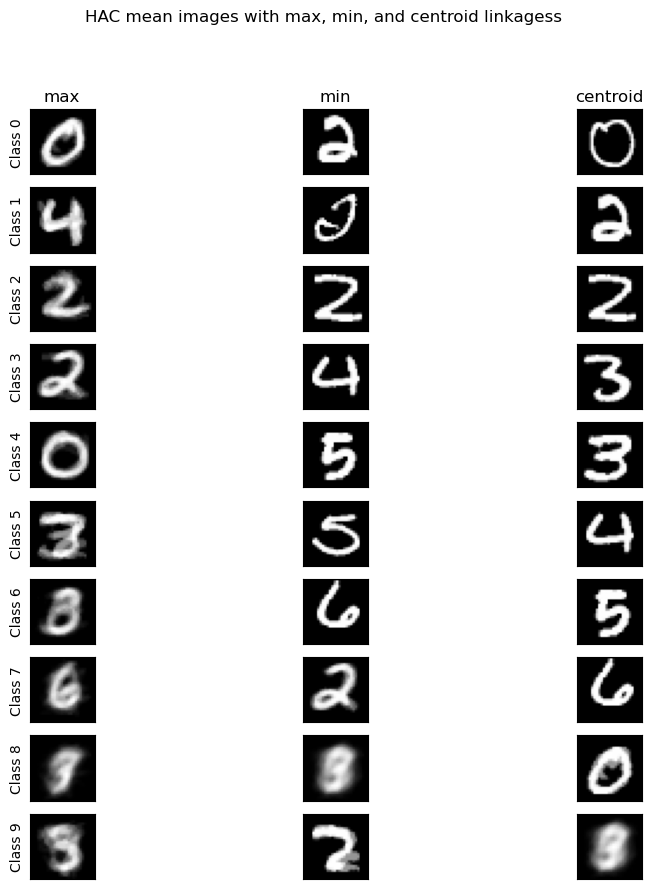

In [28]:
LINKAGES = [ 'max', 'min', 'centroid' ]
n_clusters = 10
cluster_sizes = []

fig = plt.figure(figsize=(10,10))
plt.suptitle("HAC mean images with max, min, and centroid linkagess")
for l_idx, l in enumerate(LINKAGES):
    # Fit HAC
    hac = HAC(l)
    hac.fit(small_dataset)
    mean_images = hac.get_mean_images(n_clusters)
    cluster_sizes.append(hac.get_cluster_sizes(n_clusters)) # used in Part 8, append here to avoid re-fitting
    # Make plot
    for m_idx in range(mean_images.shape[0]):
        m = mean_images[m_idx]
        ax = fig.add_subplot(n_clusters, len(LINKAGES), l_idx + m_idx*len(LINKAGES) + 1)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        if m_idx == 0: plt.title(l)
        if l_idx == 0: ax.set_ylabel('Class '+str(m_idx), rotation=90)
        plt.imshow(m.reshape(28,28), cmap='Greys_r')
    print("Done:", l)
plt.show()

### Part 5

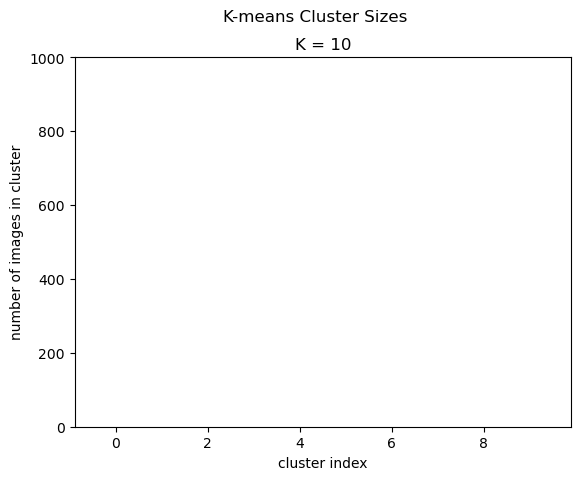

In [29]:
# Part 5: Create the graph for comparing cluster sizes in K-means
def plot_cluster_sizes(n_clusters, cluster_sizes):
    fig, (ax) = plt.subplots(1, 1)
    fig.suptitle("K-means Cluster Sizes")
    ax.set_ylabel('number of images in cluster')
    cluster_idxs = [i for i in range(n_clusters)]

    def plot_sizes_per_linkage(ax, sizes, k):
        ax.bar(cluster_idxs, sizes)
        ax.set_title(f'K = {k}')
        ax.set_xlabel('cluster index')
        ax.set_ylim(0, 1000)

    plot_sizes_per_linkage(ax, cluster_sizes, str(n_clusters))
    plt.show()

plot_cluster_sizes(KMeansClassifier.K, KMeansClassifier.get_cluster_sizes())

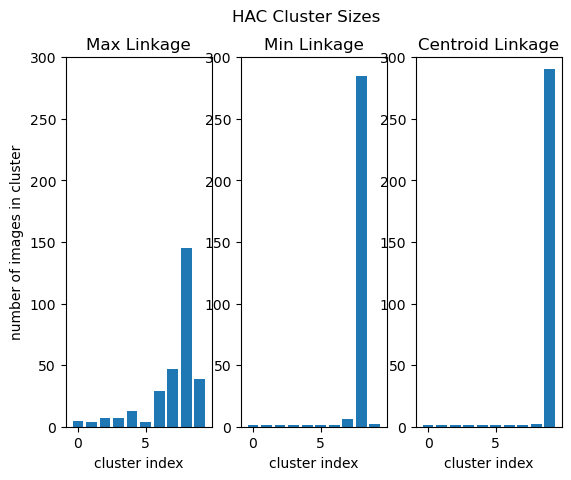

In [30]:
# Part 5: Create the graph for comparing cluster sizes in HAC
def plot_cluster_sizes(n_clusters, cluster_sizes):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle("HAC Cluster Sizes")
    ax1.set_ylabel('number of images in cluster')
    cluster_idxs = [i for i in range(n_clusters)]

    def plot_sizes_per_linkage(ax, sizes, linkage):
        ax.bar(cluster_idxs, sizes)
        ax.set_title(f'{linkage} Linkage')
        ax.set_xlabel('cluster index')
        ax.set_ylim(0, 300)

    plot_sizes_per_linkage(ax1, cluster_sizes[0], 'Max')
    plot_sizes_per_linkage(ax2, cluster_sizes[1], 'Min')
    plot_sizes_per_linkage(ax3, cluster_sizes[2], 'Centroid')
    plt.show()
plot_cluster_sizes(n_clusters, cluster_sizes)

### Part 6: Confusion Matrix

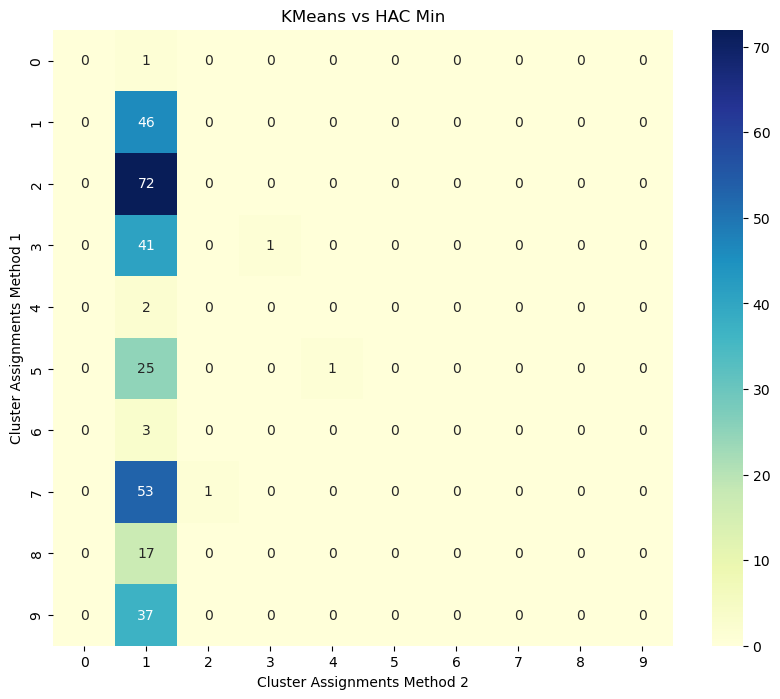

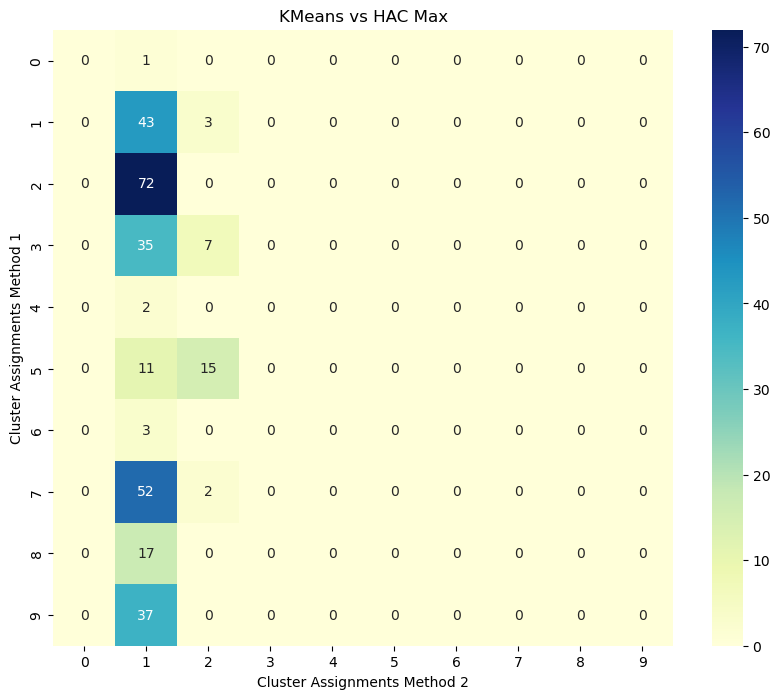

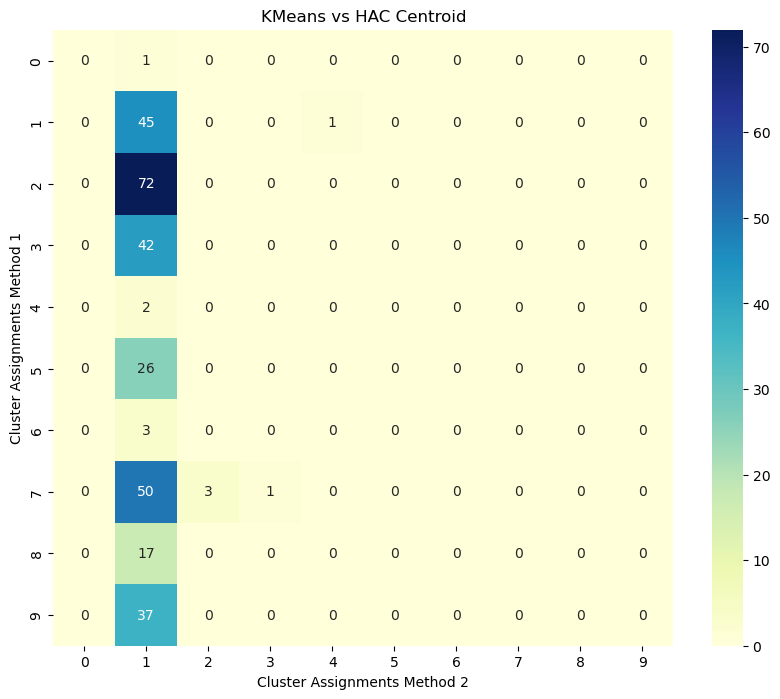

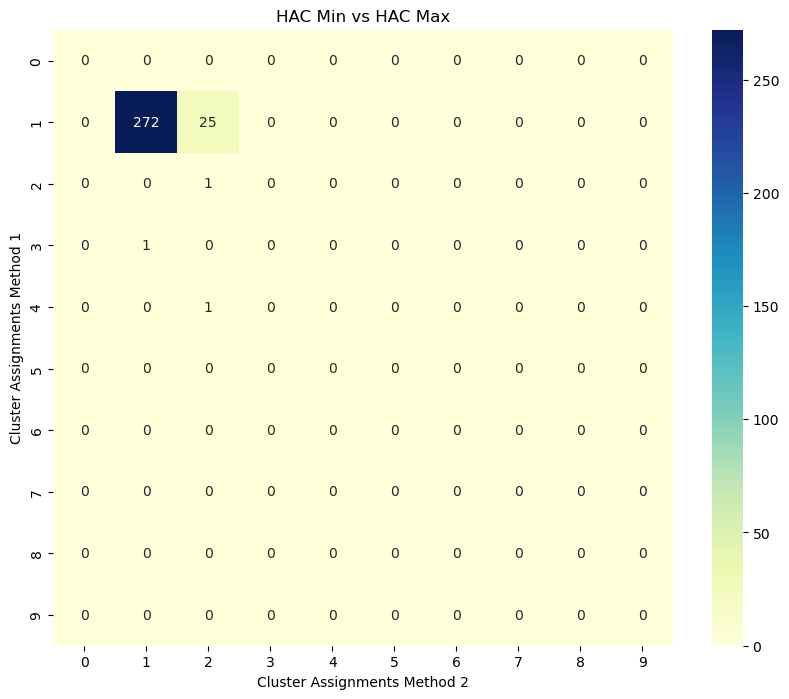

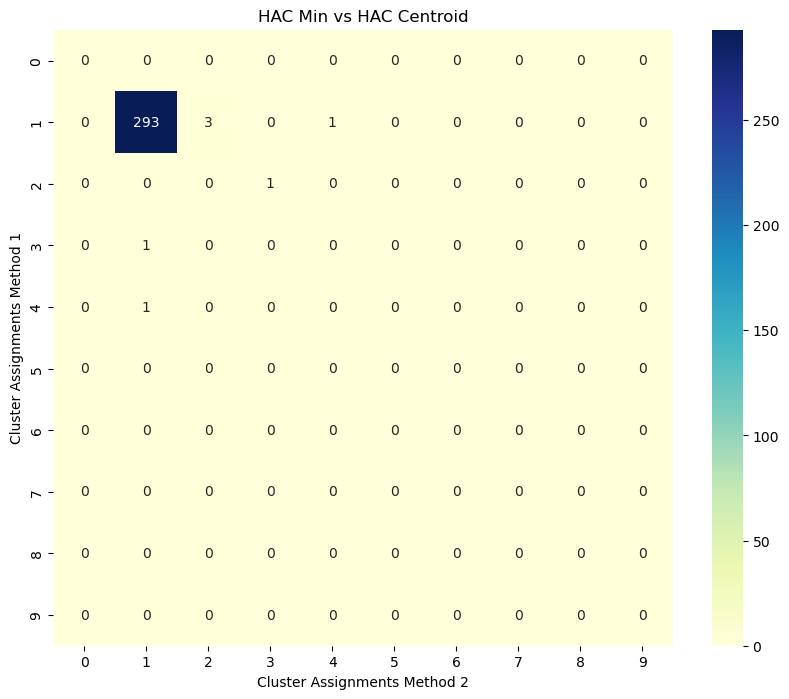

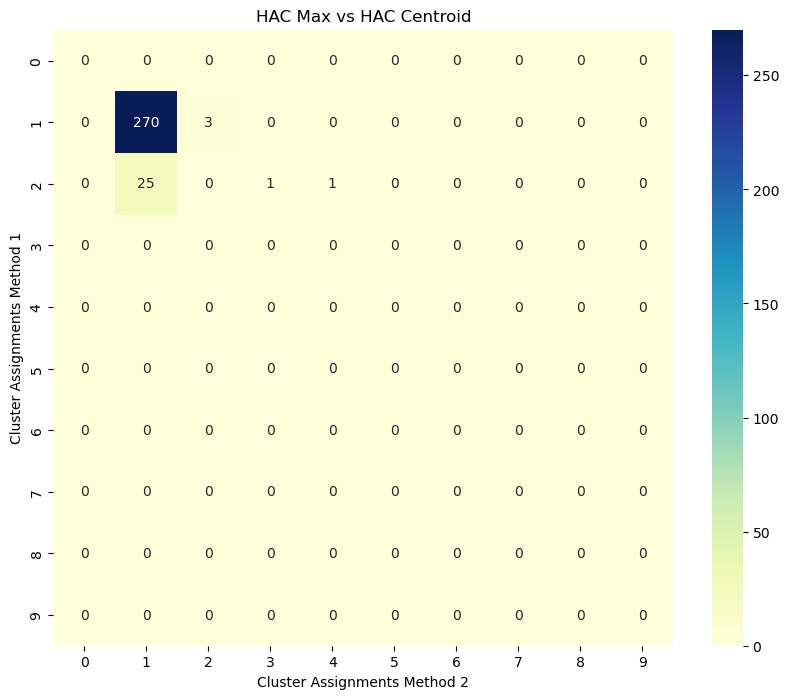

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the KMeans and HAC classes are defined as previously shown

def fit_and_get_assignments(model, data, K=10):
    """
    Fit the model and return cluster assignments.
    
    :param model: The clustering model to fit (KMeans or HAC)
    :param data: The dataset to fit the model on
    :param K: The number of clusters (for KMeans) or final clusters (for HAC)
    :return: Array of cluster assignments
    """
    model.fit(data)
    if isinstance(model, KMeans):
        return model.cluster_assignments
    else:  # HAC
        return np.array([np.argmin([np.mean(np.linalg.norm(data[i] - model.get_mean_images(K), axis=1)) for K in range(10)]) for i in range(len(data))])

def get_confusion_matrix(assignments1, assignments2, K=10):
    confusion_matrix = np.zeros((K, K), dtype=int)
    for i in range(K):
        indices1 = np.where(assignments1 == i)[0]
        for j in range(K):
            indices2 = np.where(assignments2 == j)[0]
            confusion_matrix[i, j] = len(np.intersect1d(indices1, indices2))
    return confusion_matrix

def plot_confusion_matrix(confusion_matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(title)
    plt.xlabel("Cluster Assignments Method 2")
    plt.ylabel("Cluster Assignments Method 1")
    plt.show()

# Load your dataset
# small_dataset = np.load("~/school/cs181/cs181-s24-homeworks/hw4/data/small_dataset_labels.npy")

# Initialize and fit models
K = 10
kmeans = KMeans(K)
kmeans_assignments = fit_and_get_assignments(kmeans, small_dataset)

hac_models = {
    'min': HAC('min'),
    'max': HAC('max'),
    'centroid': HAC('centroid')
}
hac_assignments = {
    linkage: fit_and_get_assignments(model, small_dataset, K)
    for linkage, model in hac_models.items()
}


# Generate and plot confusion matrices
for hac_linkage, assignments in hac_assignments.items():
    confusion_matrix = get_confusion_matrix(kmeans_assignments, assignments, K)
    plot_confusion_matrix(confusion_matrix, f"KMeans vs HAC {hac_linkage.capitalize()}")

for i, (linkage1, assignments1) in enumerate(hac_assignments.items()):
    for linkage2, assignments2 in list(hac_assignments.items())[i+1:]:
        confusion_matrix = get_confusion_matrix(assignments1, assignments2, K)
        plot_confusion_matrix(confusion_matrix, f"HAC {linkage1.capitalize()} vs HAC {linkage2.capitalize()}")
